# Loss Given Default and Exposure at Default Model

## Import Libraries and Loan Data

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load the Preprocessed Loan Data

Load the dataset **loan_data_preprocessed.csv** from Preparation notebook.

In [2]:
loan_data_preprocessed_backup = pd.read_csv('loan_data_preprocessed.csv')
loan_data_preprocessed = loan_data_preprocessed_backup.copy()

/var/folders/hn/11hmxl5x72jg2t7k7m1krds80000gn/T/ipykernel_44366/3265462501.py:1: DtypeWarning: Columns (20,48,56,113,124,125,126,129,130,131,134,140,141,142) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data_preprocessed_backup = pd.read_csv('loan_data_preprocessed.csv')


### Explore and Prepare the Data

In [3]:
loan_data_preprocessed.shape

(2260668, 279)

Select the data from borrowers that have enough time to repay part of the remaining debt. In case of this Lending Club loan data, the accounts that were written-off (**loan_status** is either **Charged Off** or **Does not meet the credit policy. Status:Charged Off**) are selected.

In [4]:
loan_data_preprocessed['loan_status'].unique()

array(['Current', 'Fully Paid', 'Late (31-120 days)', 'In Grace Period',
       'Charged Off', 'Late (16-30 days)', 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [5]:
loan_data_defaults = loan_data_preprocessed[loan_data_preprocessed['loan_status'].isin(['Charged Off', 
                                                                                       'Does not meet the credit policy. Status:Charged Off'])].copy()
loan_data_defaults.head(10)

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w
5040,5040,NaN,NaN,8000,8000,8000.0,36 months,6.46,245.05,A,...,False,False,False,False,True,False,False,False,False,True
25963,25963,NaN,NaN,6000,6000,6000.0,36 months,14.47,206.44,C,...,False,False,False,False,False,False,False,False,True,False
41393,41393,NaN,NaN,10000,10000,10000.0,36 months,8.81,317.12,A,...,False,False,False,False,False,False,False,False,False,True
55148,55148,NaN,NaN,10000,10000,10000.0,60 months,27.27,306.97,E,...,False,False,False,False,False,False,False,False,False,True
58105,58105,NaN,NaN,35000,35000,35000.0,36 months,16.14,1232.92,C,...,False,False,False,False,True,False,False,False,False,True
60604,60604,NaN,NaN,4800,4800,4800.0,36 months,16.91,170.92,C,...,False,False,True,False,False,False,False,False,False,True
62536,62536,NaN,NaN,35000,35000,35000.0,36 months,14.47,1204.23,C,...,True,False,False,False,False,False,False,False,False,True
64081,64081,NaN,NaN,15000,15000,15000.0,36 months,11.31,493.29,B,...,False,False,False,False,True,False,False,False,False,True
67928,67928,NaN,NaN,16000,16000,15975.0,60 months,10.08,340.59,B,...,False,False,False,False,False,False,False,False,True,False
68761,68761,NaN,NaN,25000,25000,25000.0,36 months,6.46,765.77,A,...,False,False,False,False,False,False,False,False,False,True


In [6]:
loan_data_defaults['loan_status'].unique()

array(['Charged Off',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [7]:
loan_data_defaults.shape

(262416, 279)

In [8]:
pd.options.display.max_rows = None
loan_data_defaults.isnull().sum()

Unnamed: 0                                                              0
id                                                                 262416
member_id                                                          262416
loan_amnt                                                               0
funded_amnt                                                             0
funded_amnt_inv                                                         0
term                                                                    0
int_rate                                                                0
installment                                                             0
grade                                                                   0
sub_grade                                                               0
emp_title                                                           21743
emp_length                                                          20409
home_ownership                        

## Independent Variables

Preprocess independent variables **mths_since_last_delinq** and **mths_since_last_record**

In [9]:
loan_data_defaults.fillna({'mths_since_last_delinq': 0}, inplace = True)
loan_data_defaults.fillna({'mths_since_last_record': 0}, inplace = True)

## Dependent Variable

### Prepare Dependent Variable

For defaulted borrowers, **funded_amnt** reflects the total amound that was lost the moment the borrowers defaulted.

In [10]:
loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']
loan_data_defaults['recovery_rate'].describe()

count    262416.000000
mean          0.073270
std           0.094347
min           0.000000
25%           0.000000
50%           0.058417
75%           0.110310
max           2.170300
Name: recovery_rate, dtype: float64

Based on the column description, all metrics are expected except metric **max** which is larger than 1 since the recovery rate is a rate ranging from 0 to 1.

In [11]:
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'].describe()

count    262416.000000
mean          0.073240
std           0.094011
min           0.000000
25%           0.000000
50%           0.058417
75%           0.110310
max           1.000000
Name: recovery_rate, dtype: float64

The variable Total Recovery Principal, **total_rec_prncp**, reflects the total payments made on the principal of the loan. We need to calculate the credit conversion factor (CCF) to calculate the EAD (Exposure at Default) as the following
$$
EAD = total\_funded\_amount * CCF
$$

In [12]:
loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp']) / loan_data_defaults['funded_amnt']
loan_data_defaults['CCF'].describe()

count    262416.000000
mean          0.698281
std           0.218080
min           0.000000
25%           0.568441
50%           0.748344
75%           0.872427
max           1.000000
Name: CCF, dtype: float64

### Explore Dependent Variable

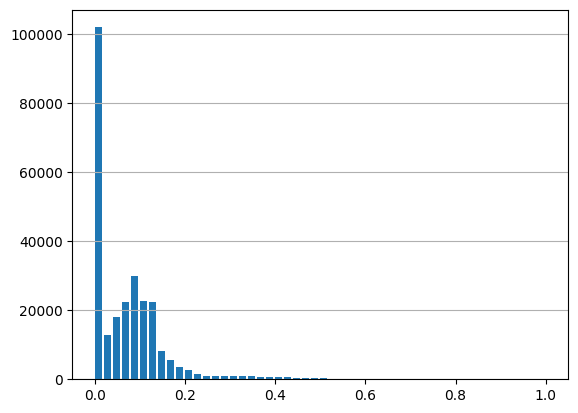

In [13]:
plt.hist(loan_data_defaults['recovery_rate'], bins = 50, width = 0.015555)
plt.grid(axis = 'y')

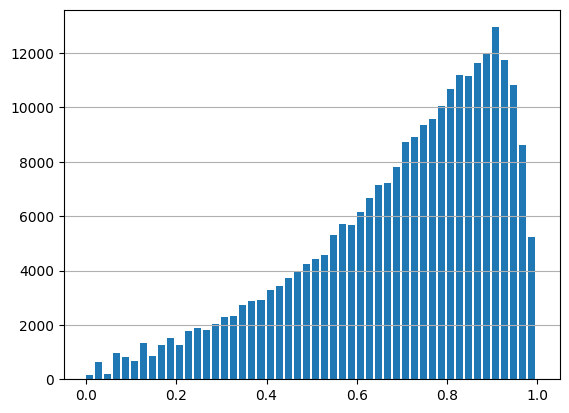

In [14]:
plt.hist(loan_data_defaults['CCF'], bins = 50, width = 0.015555)
plt.grid(axis = 'y')

In [15]:
loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)
loan_data_defaults['recovery_rate_0_1'].head(10)

5040     0
25963    0
41393    0
55148    0
58105    0
60604    0
62536    0
64081    0
67928    0
68761    0
Name: recovery_rate_0_1, dtype: int64

## LGD Model

### Split the Data

Split the dataframe into 80% training data and 20% testing data and set **random_state** to 20.

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
lgd_inputs_stage1_train, lgd_inputs_stage1_test, lgd_targets_stage1_train, lgd_targets_stage1_test = train_test_split(loan_data_defaults.drop(['recovery_rate', 'recovery_rate_0_1', 'CCF'], axis = 1), loan_data_defaults['recovery_rate_0_1'], test_size = 0.2, random_state = 20)

Observe the training inputs and targets dataframe.

In [26]:
lgd_inputs_stage1_train.shape

(209932, 279)

In [27]:
lgd_targets_stage1_train.shape

(209932,)

Observe the testing inputs and targets dataframe.

In [28]:
lgd_inputs_stage1_test.shape

(52484, 279)

In [29]:
lgd_targets_stage1_test.shape

(52484,)

### Prepare the Inputs Data